This notebook created based on the following notebooks:

- http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
- https://github.com/cstjean/ScikitLearn.jl/blob/master/examples/Classifier_Comparison.ipynb

In [1]:
require 'matplotlib/iruby'
Matplotlib::IRuby.activate
plt = Matplotlib::Pyplot
mplc = Matplotlib.colors

nil

In [2]:
require 'pycall/import'
include PyCall::Import

pyimport 'numpy', as: :np
pyfrom 'sklearn.model_selection', import: :train_test_split
pyfrom 'sklearn.preprocessing', import: :StandardScaler
pyfrom 'sklearn.datasets', import: %i(make_moons make_circles make_classification)
pyfrom 'sklearn.neighbors', import: :KNeighborsClassifier
pyfrom 'sklearn.svm', import: :SVC
pyfrom 'sklearn.tree', import: :DecisionTreeClassifier
pyfrom 'sklearn.ensemble', import: %i(RandomForestClassifier AdaBoostClassifier)
pyfrom 'sklearn.naive_bayes', import: :GaussianNB
pyfrom 'sklearn.discriminant_analysis', import: %i(LinearDiscriminantAnalysis QuadraticDiscriminantAnalysis)

nil

In [3]:
h = 0.02  # step size in the mesh

names = [
  'Nearest Neighbors',
  'Linear SVM',
  'RBF SVM',
  'Decision Tree',
  'Random Forest',
  'AdaBoost',
  'Naive Bayes',
  'Linear Discriminant Analysis',
  'Quadratic Discriminant Analysis'
]

classifiers = [
  KNeighborsClassifier.new(3),
  SVC.new(kernel: 'linear', C: 0.025),
  SVC.new(gamma: 2, C: 1),
  DecisionTreeClassifier.new(max_depth: 5),
  RandomForestClassifier.new(max_depth: 5, n_estimators: 10, max_features: 1),
  AdaBoostClassifier.new,
  GaussianNB.new,
  LinearDiscriminantAnalysis.new,
  QuadraticDiscriminantAnalysis.new
]

x, y = *make_classification(
  n_features: 2,
  n_redundant: 0,
  n_informative: 2,
  random_state: 1,
  n_clusters_per_class: 1
)

np.random.seed(42)
x += 2 * np.random.random_sample(x.shape)
linearly_separable = [x, y]

datasets = [
  make_moons(noise: 0.3, random_state: 0),
  make_circles(noise: 0.2, factor: 0.5, random_state: 1),
  linearly_separable
]

nil

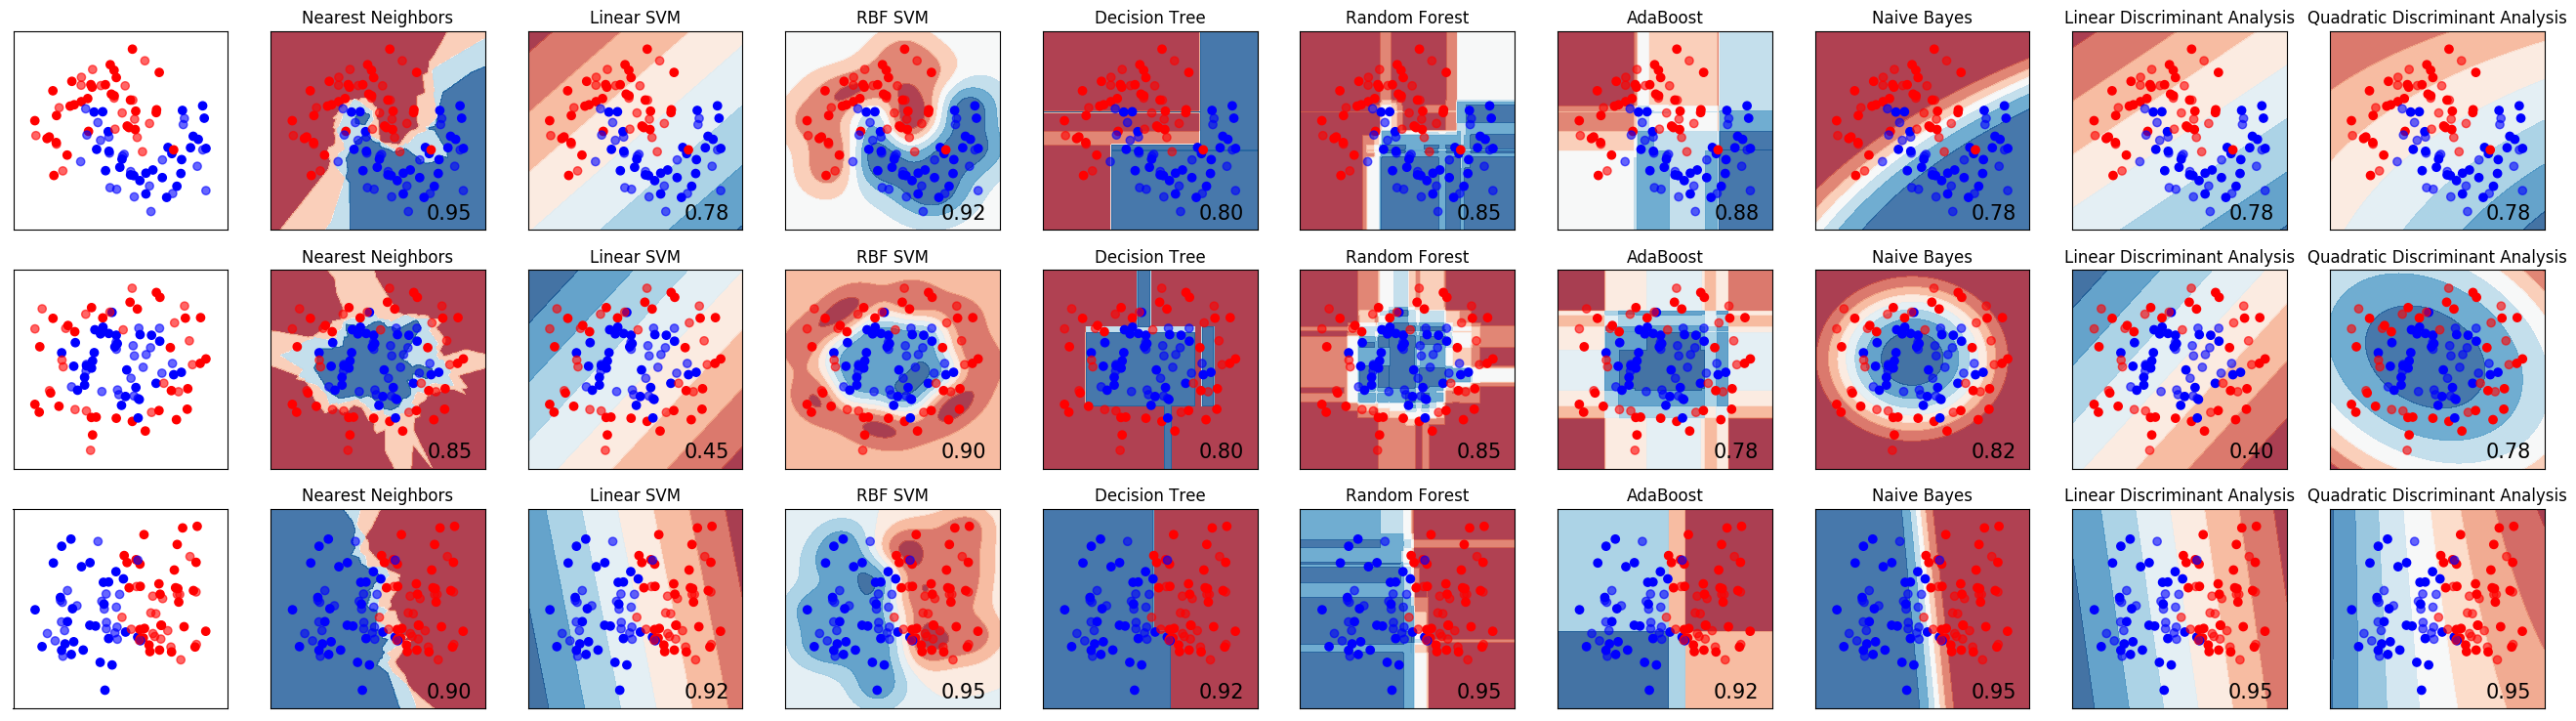

In [4]:
fig = plt.figure(figsize: [27, 9])
i = 1
all = 0..-1

# iterate over datasets
datasets.each do |ds|
  # preprocess dataset, split into training and test part
  x, y = *ds
  x = StandardScaler.new.fit_transform(x)
  x_train, x_test, y_train, y_test = *train_test_split(x, y, test_size: 0.4)

  x_min, x_max = np.min(x[all, 0]) - 0.5, np.max(x[all, 0]) + 0.5
  y_min, y_max = np.min(x[all, 1]) - 0.5, np.max(x[all, 1]) + 0.5

  xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, ((x_max - x_min)/h).round),
    np.linspace(y_min, y_max, ((y_max - y_min)/h).round),
  )
  mesh_points = np.dstack([xx.ravel, yy.ravel])[0, all, all]

  # just plot the dataset first
  cm = plt.cm.__dict__[:RdBu]
  cm_bright = mplc.ListedColormap.new(["#FF0000", "#0000FF"])
  ax = plt.subplot(datasets.length, classifiers.length + 1, i)
  # plot the training points
  ax.scatter(x_train[all, 0], x_train[all, 1], c: y_train, cmap: cm_bright)
  # and testing points
  ax.scatter(x_test[all, 0], x_test[all, 1], c: y_test, cmap: cm_bright, alpha: 0.6)

  ax.set_xlim(np.min(xx), np.max(xx))
  ax.set_ylim(np.min(yy), np.max(yy))
  ax.set_xticks([])
  ax.set_yticks([])
  i += 1

  # iterate over classifiers
  names.zip(classifiers).each do |name, clf|
    ax = plt.subplot(datasets.length, classifiers.length + 1, i)
    clf.fit(x_train, y_train)
    scor = clf.score(x_test, y_test)

    # Plot the decision boundary.  For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max]
    begin
      # not implemented for some
      z = clf.decision_function(mesh_points)
    rescue
      z = clf.predict_proba(mesh_points)[all, 1]
    end

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    ax.contourf(xx, yy, z, cmap: cm, alpha: 0.8)

    # Plot also the training points
    ax.scatter(x_train[all, 0], x_train[all, 1], c: y_train, cmap: cm_bright)
    # and testing points
    ax.scatter(x_test[all, 0], x_test[all, 1], c: y_test, cmap: cm_bright, alpha: 0.6)

    ax.set_xlim(np.min(xx), np.max(xx))
    ax.set_ylim(np.min(yy), np.max(yy))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)

    ax.text(np.max(xx) - 0.3, np.min(yy) + 0.3, "%.2f" % scor, size: 15, horizontalalignment: 'right')

    i += 1
  end
end

fig.subplots_adjust(left: 0.02, right: 0.98)